In [12]:
from imp import reload
import glob
import os

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

save_to = 'model_training/'
if not os.path.exists(save_to):
    os.makedirs(save_to)

In [3]:
img_file_names_vehicle = \
        glob.glob(os.path.join('./data', 'vehicles', '*', '*.png'))
img_file_names_nonvehicle = \
        glob.glob(os.path.join('./data', 'non-vehicles', '*', '*.png'))

### Feature Extraction

In [11]:
%%time

from utils.feature_extraction import extract_features; reload(feature_extraction)

color_space='YCrCb'
bin_spatial_size = (32, 32)
n_hist_bins=32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
bin_spatial_feature = True
color_hist_feature = True
hog_feature = True

car_features = extract_features(
    img_file_names_vehicle, 
    color_space=color_space, 
    bin_spatial_size=bin_spatial_size, n_hist_bins=n_hist_bins, 
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    bin_spatial_feature=bin_spatial_feature, color_hist_feature=color_hist_feature, hog_feature=hog_feature)

notcar_features = extract_features(
    img_file_names_nonvehicle, 
    color_space=color_space, 
    bin_spatial_size=bin_spatial_size, n_hist_bins=n_hist_bins, 
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    bin_spatial_feature=bin_spatial_feature, color_hist_feature=color_hist_feature, hog_feature=hog_feature)

# Stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Stack of label vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

CPU times: user 1min 15s, sys: 7.59 s, total: 1min 23s
Wall time: 1min 34s


In [13]:
X.shape

(17760, 8460)

### Feature Scaling

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

from sklearn.externals import joblib
joblib.dump(scaler, os.path.join(save_to, 'standard_scaler.pkl'))

['model_training/standard_scaler.pkl']

### Train, Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_train_origin, X_test, y_train_origin, y_test = \
    train_test_split(X_scaled, y, random_state=0, stratify=y)

### Training Linear SVM
- 5-Fold Cross Validation

In [16]:
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC


# DataFrame to record cross validation result
df_cv_linear_svc = pd.DataFrame()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for i, (train_index, test_index) in enumerate(skf.split(X_train_origin, y_train_origin)):
    print('Start Fold {}'.format(i + 1))
    t0_fold = time.time()

    X_train, y_train = X_train_origin[train_index], y_train_origin[train_index]
    X_val, y_val = X_train_origin[test_index], y_train_origin[test_index]

    clf = LinearSVC()
    t0_fit = time.time()
    clf.fit(X_train, y_train)
    print('Fit in {}'.format(time.time() - t0_fit))

    df_cv_linear_svc.loc[i, 'acc'] = clf.score(X_train, y_train)
    df_cv_linear_svc.loc[i, 'val_acc'] = clf.score(X_val, y_val)
    
    print('Fold {} in {}'.format(i + 1, time.time() - t0_fold))

print(df_cv_linear_svc)

Start Fold 1
Fit in 12.136549949645996
Fold 1 in 16.643779039382935
Start Fold 2
Fit in 23.86414098739624
Fold 2 in 26.42292809486389
Start Fold 3
Fit in 4.232697010040283
Fold 3 in 5.055583953857422
Start Fold 4
Fit in 4.662035942077637
Fold 4 in 5.376140117645264
Start Fold 5
Fit in 5.802411079406738
Fold 5 in 7.160552024841309
   acc   val_acc
0  1.0  0.995122
1  1.0  0.987988
2  1.0  0.991366
3  1.0  0.994369
4  1.0  0.990988


In [18]:
print('mean val_acc = {}'.format(df_cv_linear_svc['val_acc'].mean()))

mean val_acc = 0.9919666565808365


### Test

In [19]:
%%time

# Train for test
clf = LinearSVC()
clf.fit(X_train_origin, y_train_origin)

# Model persistence
from sklearn.externals import joblib
joblib.dump(clf, os.path.join(save_to, 'linear_svm.pkl'))

# Test accuracy
%time print('test acc = ', clf.score(X_test, y_test))

test acc =  0.990315315315
CPU times: user 98.5 ms, sys: 418 ms, total: 516 ms
Wall time: 1.06 s
CPU times: user 5.79 s, sys: 4.09 s, total: 9.88 s
Wall time: 13.6 s


### Vehicle Detection example

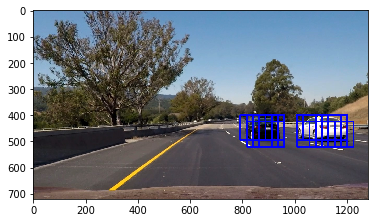

In [27]:
import utils.feature_extraction; reload(feature_extraction)

img = mpimg.imread('test_images/test6.jpg')

ystart = 400
ystop = 656
scale = 1.5
   
img_output = feature_extraction.find_cars(
    img, 
    ystart, ystop, scale, 
    clf, scaler, 
    color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
    bin_spatial_size, 
    n_hist_bins)
plt.imshow(img_output)
plt.show()